In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
from pathlib import Path

#src = str(Path.cwd().resolve().parents[1]/ 'src')
#src = str(Path.cwd().resolve().parents[2]/ 'src')
src = '/content/drive/MyDrive/dataHN/src'
sys.path.append(src)

# Now you can import your paths
from config.paths import ROOT, DATA, EXPERIMENTS, DOC_IMGS, CLEANED, PROCESSED, METADATA


In [ ]:
ROOT = '/content/drive/MyDrive/dataHN'
DOC_IMGS = '/content/drive/MyDrive/dataHN/data/raw_selected/doc_imgs'
EXPERIMENTS = '/content/drive/MyDrive/dataHN/experiments'
DATA = '/content/drive/MyDrive/dataHN/data'
CLEANED = '/content/drive/MyDrive/dataHN/data/cleaned'
PROCESSED = '/content/drive/MyDrive/dataHN/data/processed'
METADATA = '/content/drive/MyDrive/dataHN/metadata'

In [ ]:
pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 28.2 MB/s eta 0:00:00


# Préparation des données

In [ ]:
from ultralytics import YOLO
import os
import shutil
from sklearn.model_selection import train_test_split
import numpy as np
from tqdm import tqdm
import torch
import pandas as pd

In [ ]:
# YOLO experiment dir
yolo_dir = os.path.join(EXPERIMENTS, 'yolo_doc_ill_detect')
data_dir = os.path.join(yolo_dir, 'data')

train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val')
os.makedirs(train_dir, exist_ok = True)
os.makedirs(val_dir, exist_ok = True)

In [ ]:
# Données :images et annotations de documents non filtrés, avec pages blanches
# raw_labels_dir = os.path.join(yolo_dir, 'dataset','labels')
# raw_training_img_dir = os.path.join(yolo_dir, 'dataset','img')
labels_dir = os.path.join(yolo_dir, 'dataset_1024','labels')
training_img_dir = os.path.join(yolo_dir, 'dataset_1024','img') # img redimensionnées pour execution sur colab



In [ ]:
liste_img_data= [os.path.join(training_img_dir, img) for img in os.listdir(training_img_dir)]
liste_labels_data= [os.path.join(labels_dir, label) for label in os.listdir(labels_dir)]


### Split

In [ ]:
image_label = list(zip(liste_img_data, liste_labels_data))

In [ ]:
train_pair, val_pair = train_test_split(image_label, test_size=0.2, random_state=42)

In [ ]:
def copy_files(pairs, dest_img_dir, dest_labels_dir):
    for img_path, label_path in pairs:
        shutil.copy(img_path, dest_img_dir)

        if os.path.exists(label_path):
            shutil.copy(label_path, dest_labels_dir)
        else:
            print(f"Annotation manquante  : {label_path}")

### Configurer stockage local colab

In [ ]:
train_dir_colab = '/content/data/train'
val_dir_colab = '/content/data/val'

train_dir = train_dir_colab
val_dir = val_dir_colab
os.makedirs(os.path.join(train_dir, 'images'), exist_ok = True)
os.makedirs(os.path.join(train_dir, 'labels'), exist_ok = True)

os.makedirs(os.path.join(val_dir, 'images'), exist_ok = True)
os.makedirs(os.path.join(val_dir, 'labels'), exist_ok = True)

In [ ]:
training_dir = os.path.join(yolo_dir, 'training')
config = os.path.join(training_dir, 'config.yaml')
config_colab = '/content/data/config.yaml'
shutil.copy(config, config_colab)
config=config_colab

### Déplacer data vers dir train et val

In [ ]:
copy_files(train_pair, os.path.join(train_dir, "images"), os.path.join(train_dir, "labels"))

In [ ]:
copy_files(val_pair, os.path.join(val_dir, "images"), os.path.join(val_dir, "labels"))

In [ ]:
print(len(os.listdir(os.path.join(train_dir, "images"))+os.listdir(os.path.join(val_dir, "images"))))
print(len(os.listdir(os.path.join(train_dir, "labels"))+os.listdir(os.path.join(val_dir, "labels"))))

423
423


# Entraînement YOLO

## Config

In [ ]:

model_name = 'yolo11m.pt'
num_training = 8
training_dir = os.path.join(yolo_dir, 'training')

project = os.path.join(training_dir, 'runs')
#name = f'run{num_training}_{model_name.split(".")[0]}'


In [ ]:
name = f'run{num_training}_{model_name.split(".")[0]}_1024'


In [ ]:
#config = os.path.join(training_dir, 'config.yaml')
epochs = 70
batch = 16
dropout = 0.1
imgsz=640

### Config dir data sur espace de stockage Colab pour accélere entraînement

## Entraînement

In [ ]:
model = YOLO(model_name)

results = model.train(
    data=config,
    epochs=epochs,
    batch = batch,
    dropout=dropout,
    project = project,
    name = name
)


Ultralytics 8.3.179 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/data/config.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.1, dynamic=False, embed=None, epochs=70, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=run8_yolo11m_1024, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, p

Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  1                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  2                  -1  1    111872  ultralytics.nn.modules.block.C3k2            [128, 256, 1, True, 0.25]     
  3                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  4                  -1  1    444928  ultralytics.nn.modules.block.C3k2            [256, 512, 1, True, 0.25]     
  5                  -1  1   2360320  ultralytics.nn.modules.conv.Conv             [512, 512, 3, 2]              
  6                  -1  1   1380352  ultralytics.nn.modules.block.C3k2            [512, 512, 1, True]           
  7                  -1  1   2360320  ultralytics

 13                  -1  1   1642496  ultralytics.nn.modules.block.C3k2            [1024, 512, 1, True]          
 14                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 15             [-1, 4]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 16                  -1  1    542720  ultralytics.nn.modules.block.C3k2            [1024, 256, 1, True]          
 17                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
 18            [-1, 13]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 19                  -1  1   1511424  ultralytics.nn.modules.block.C3k2            [768, 512, 1, True]           
 20                  -1  1   2360320  ultralytics.nn.modules.conv.Conv             [512, 512, 3, 2]              
 21            [-1, 10]  1         0  ultralytics.nn.modules.conv.Concat           [1]  

AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1838.7±765.7 MB/s, size: 131.8 KB)


train: Scanning /content/data/train/labels... 322 images, 21 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<00:00, 2271.35it/s]

train: New cache created: /content/data/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1254.1±803.6 MB/s, size: 206.7 KB)


val: Scanning /content/data/val/labels... 69 images, 17 backgrounds, 0 corrupt: 100%|██████████| 85/85 [00:00<00:00, 1884.47it/s]

val: New cache created: /content/data/val/labels.cache


Plotting labels to /content/drive/MyDrive/dataHN/experiments/yolo_doc_ill_detect/training/runs/run8_yolo11m_1024/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 106 weight(decay=0.0), 113 weight(decay=0.0005), 112 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/dataHN/experiments/yolo_doc_ill_detect/training/runs/run8_yolo11m_1024
Starting training for 70 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/70      8.03G      1.072      1.936      1.179         21        640: 100%|██████████| 22/22 [00:14<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.35it/s]

                   all         85        242       0.52      0.649      0.554      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/70      8.29G      1.074      1.228      1.216         10        640: 100%|██████████| 22/22 [00:13<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.98it/s]

                   all         85        242    0.00327      0.103    0.00181   0.000416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/70      8.29G      1.162      1.155      1.265         10        640: 100%|██████████| 22/22 [00:13<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.49it/s]

                   all         85        242          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/70       8.2G       1.19      1.349       1.32          3        640: 100%|██████████| 22/22 [00:13<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]

                   all         85        242    0.00495      0.112    0.00261   0.000922



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/70      8.22G      1.119      1.186      1.255         10        640: 100%|██████████| 22/22 [00:13<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.63it/s]

                   all         85        242    0.00314     0.0124   0.000654   0.000221



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/70      8.24G      1.144      1.139      1.279          7        640: 100%|██████████| 22/22 [00:13<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.61it/s]

                   all         85        242     0.0314     0.0413    0.00709    0.00334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/70      8.17G       1.12      1.013      1.256         10        640: 100%|██████████| 22/22 [00:13<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.54it/s]

                   all         85        242     0.0685      0.112      0.016    0.00644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/70      8.31G      1.063     0.9701      1.214         22        640: 100%|██████████| 22/22 [00:13<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.80it/s]

                   all         85        242     0.0673      0.103     0.0153    0.00652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/70       8.2G      1.046     0.9809      1.234         10        640: 100%|██████████| 22/22 [00:13<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.70it/s]

                   all         85        242      0.158       0.15     0.0461     0.0249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/70      8.26G       1.02     0.9318      1.182         16        640: 100%|██████████| 22/22 [00:13<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.21it/s]

                   all         85        242      0.603      0.401      0.474      0.268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/70      8.23G     0.9809     0.8466      1.198          9        640: 100%|██████████| 22/22 [00:14<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.52it/s]

                   all         85        242      0.646      0.747      0.672      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/70      8.28G      1.002     0.8966      1.182          7        640: 100%|██████████| 22/22 [00:14<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.05it/s]

                   all         85        242      0.458      0.351      0.303      0.169



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/70      8.22G     0.9658     0.8734      1.171         13        640: 100%|██████████| 22/22 [00:13<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.45it/s]

                   all         85        242      0.362       0.45      0.331      0.168



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/70      8.28G     0.9559      0.776       1.15          7        640: 100%|██████████| 22/22 [00:13<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.49it/s]

                   all         85        242       0.46       0.38      0.297      0.192



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/70      8.26G     0.9309      1.407       1.15          1        640: 100%|██████████| 22/22 [00:13<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.91it/s]

                   all         85        242      0.599      0.756        0.7      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/70      8.25G     0.9248     0.7785      1.149         12        640: 100%|██████████| 22/22 [00:13<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.14it/s]

                   all         85        242      0.476      0.244      0.277      0.149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/70      8.28G     0.9152     0.8178      1.148          6        640: 100%|██████████| 22/22 [00:13<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.56it/s]

                   all         85        242      0.488      0.334      0.348      0.223



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/70       8.3G     0.9194     0.8207      1.143         19        640: 100%|██████████| 22/22 [00:14<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.54it/s]

                   all         85        242      0.655      0.517      0.602      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/70      8.25G     0.8693     0.7674      1.119          9        640: 100%|██████████| 22/22 [00:13<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.60it/s]

                   all         85        242      0.556      0.528      0.484      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/70      8.26G     0.8552     0.7259      1.109         15        640: 100%|██████████| 22/22 [00:13<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.60it/s]

                   all         85        242      0.721      0.917      0.798      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/70      8.23G     0.8647      0.742      1.109          9        640: 100%|██████████| 22/22 [00:13<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.09it/s]

                   all         85        242      0.712      0.864      0.738      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/70      8.25G     0.8239     0.7357      1.083          8        640: 100%|██████████| 22/22 [00:13<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.60it/s]

                   all         85        242      0.645       0.88      0.733      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/70      8.24G     0.9001     0.7382      1.106         48        640: 100%|██████████| 22/22 [00:13<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.08it/s]

                   all         85        242      0.691       0.61      0.644      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/70      8.27G     0.8071     0.6837      1.076          5        640: 100%|██████████| 22/22 [00:13<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.98it/s]

                   all         85        242      0.748      0.612      0.671      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/70      8.21G     0.8071     0.6647      1.071         11        640: 100%|██████████| 22/22 [00:13<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.03it/s]

                   all         85        242       0.65      0.744       0.72        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/70       8.3G     0.8266     0.6713      1.058         15        640: 100%|██████████| 22/22 [00:13<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.53it/s]

                   all         85        242      0.711      0.855      0.745      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/70      8.25G     0.7818     0.6502      1.068          8        640: 100%|██████████| 22/22 [00:13<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.12it/s]

                   all         85        242      0.747      0.872        0.8      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/70      8.27G     0.7763     0.6519      1.077          7        640: 100%|██████████| 22/22 [00:13<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.17it/s]

                   all         85        242      0.642      0.521      0.554        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/70      8.27G      0.801     0.6543      1.067         10        640: 100%|██████████| 22/22 [00:13<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.04it/s]

                   all         85        242      0.769      0.777      0.794      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/70      8.25G     0.8356     0.6711      1.066         19        640: 100%|██████████| 22/22 [00:13<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.57it/s]

                   all         85        242      0.745      0.893      0.793      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/70      8.25G     0.8017     0.6194      1.079          7        640: 100%|██████████| 22/22 [00:14<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.48it/s]

                   all         85        242      0.745      0.888      0.845      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/70      8.25G     0.7668     0.6332      1.051          5        640: 100%|██████████| 22/22 [00:13<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.61it/s]

                   all         85        242      0.792      0.744       0.79       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/70      8.24G     0.7916     0.6539      1.066          8        640: 100%|██████████| 22/22 [00:13<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.08it/s]

                   all         85        242       0.73      0.888       0.79      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/70      8.25G     0.7678     0.6313       1.04         27        640: 100%|██████████| 22/22 [00:13<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.62it/s]

                   all         85        242      0.692      0.836       0.74      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/70      8.22G      0.754     0.5876      1.038         10        640: 100%|██████████| 22/22 [00:13<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.58it/s]

                   all         85        242      0.763      0.814      0.816      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/70      8.29G     0.7877     0.6242      1.048         13        640: 100%|██████████| 22/22 [00:13<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.63it/s]

                   all         85        242      0.725      0.876      0.799       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/70      8.21G     0.8114     0.6257      1.068         15        640: 100%|██████████| 22/22 [00:13<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.97it/s]

                   all         85        242      0.705      0.909      0.788      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/70      8.26G      0.725     0.5643      1.028         17        640: 100%|██████████| 22/22 [00:13<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.03it/s]

                   all         85        242      0.737       0.88      0.812      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/70      8.24G     0.7618     0.5944      1.048         11        640: 100%|██████████| 22/22 [00:13<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.59it/s]

                   all         85        242      0.742      0.909      0.784      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/70      8.25G     0.7155     0.5864       1.03          6        640: 100%|██████████| 22/22 [00:13<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.99it/s]

                   all         85        242      0.685      0.764      0.729      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/70      8.24G     0.7026     0.5622      1.021         17        640: 100%|██████████| 22/22 [00:14<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.52it/s]

                   all         85        242      0.706      0.934       0.81      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/70      8.29G     0.7341     0.6123      1.025          2        640: 100%|██████████| 22/22 [00:13<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.56it/s]

                   all         85        242      0.745      0.905      0.826       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/70      8.21G     0.7054     0.5525      1.009          9        640: 100%|██████████| 22/22 [00:13<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.17it/s]

                   all         85        242      0.739      0.851      0.833      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/70      8.29G     0.7453     0.5605      1.029         11        640: 100%|██████████| 22/22 [00:13<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.08it/s]

                   all         85        242      0.764       0.91      0.837      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/70      8.21G     0.7365     0.5518      1.034         22        640: 100%|██████████| 22/22 [00:13<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.96it/s]

                   all         85        242      0.656      0.861      0.752      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/70      8.18G      0.732     0.5727      1.035         13        640: 100%|██████████| 22/22 [00:13<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.24it/s]

                   all         85        242      0.772      0.922      0.849       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/70      8.18G     0.7457     0.5601      1.022         25        640: 100%|██████████| 22/22 [00:13<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.59it/s]

                   all         85        242      0.769      0.909      0.855      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/70      8.29G     0.6627     0.5402     0.9994          7        640: 100%|██████████| 22/22 [00:13<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.17it/s]

                   all         85        242      0.743      0.893      0.832      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/70      8.24G     0.6912     0.5142      1.017         10        640: 100%|██████████| 22/22 [00:13<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]

                   all         85        242      0.738      0.917      0.833      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/70      8.28G      0.692     0.5355      1.041          3        640: 100%|██████████| 22/22 [00:13<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.08it/s]

                   all         85        242       0.73      0.917      0.827      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/70      8.19G      0.671     0.5852     0.9989          3        640: 100%|██████████| 22/22 [00:13<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.54it/s]

                   all         85        242      0.751      0.926      0.844      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/70      8.31G     0.6762     0.5279      1.015         13        640: 100%|██████████| 22/22 [00:13<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.63it/s]

                   all         85        242      0.731      0.965      0.841       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/70      8.23G      0.643     0.5124     0.9947         20        640: 100%|██████████| 22/22 [00:14<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.50it/s]

                   all         85        242      0.779      0.873      0.846      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/70      8.29G     0.6349     0.5131      1.004         13        640: 100%|██████████| 22/22 [00:13<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.02it/s]

                   all         85        242      0.757      0.921      0.839      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/70      8.26G     0.6696     0.5088      1.026          4        640: 100%|██████████| 22/22 [00:13<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.59it/s]

                   all         85        242      0.717      0.911      0.812      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/70      8.26G     0.6455     0.4995     0.9831         22        640: 100%|██████████| 22/22 [00:13<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.61it/s]

                   all         85        242      0.782      0.901      0.815      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/70      8.28G     0.6448     0.4958     0.9775         10        640: 100%|██████████| 22/22 [00:13<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.51it/s]

                   all         85        242       0.78      0.926      0.814      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/70      8.27G     0.6226     0.4595      0.987          5        640: 100%|██████████| 22/22 [00:13<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.56it/s]

                   all         85        242      0.782      0.918       0.85      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/70      8.27G     0.5995     0.4503     0.9646          8        640: 100%|██████████| 22/22 [00:12<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.60it/s]

                   all         85        242      0.782      0.919      0.848      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/70      8.29G     0.6064       0.46     0.9814         14        640: 100%|██████████| 22/22 [00:14<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.48it/s]

                   all         85        242      0.785      0.933      0.853      0.682


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      61/70      8.23G     0.6479     0.4609     0.9891          2        640: 100%|██████████| 22/22 [00:14<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.57it/s]

                   all         85        242      0.805       0.89      0.842       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      62/70      8.27G     0.5834     0.4046     0.9309         20        640: 100%|██████████| 22/22 [00:13<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.24it/s]

                   all         85        242      0.776       0.95      0.853      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      63/70      8.24G     0.5954     0.4145      0.981          2        640: 100%|██████████| 22/22 [00:12<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.20it/s]

                   all         85        242       0.76      0.917      0.848      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      64/70      8.28G     0.6333     0.4192       1.01          2        640: 100%|██████████| 22/22 [00:13<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.54it/s]

                   all         85        242      0.763      0.917      0.848      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      65/70      8.22G     0.5792       0.38     0.9409          7        640: 100%|██████████| 22/22 [00:13<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.57it/s]

                   all         85        242      0.744      0.921      0.839       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      66/70      8.26G     0.6346     0.5097      0.983          4        640: 100%|██████████| 22/22 [00:14<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.57it/s]

                   all         85        242       0.76      0.917      0.841      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      67/70      8.24G      0.574     0.3758     0.9274          6        640: 100%|██████████| 22/22 [00:13<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.62it/s]

                   all         85        242      0.779      0.913      0.838      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      68/70      8.34G     0.5493      0.357     0.9367          3        640: 100%|██████████| 22/22 [00:13<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.53it/s]

                   all         85        242      0.779      0.933      0.846      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      69/70      8.27G     0.5706      0.371     0.9514          2        640: 100%|██████████| 22/22 [00:13<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.31it/s]

                   all         85        242      0.778      0.929      0.849      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      70/70      8.21G     0.5647     0.3918     0.9453          1        640: 100%|██████████| 22/22 [00:13<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]

                   all         85        242      0.775       0.93      0.856      0.704



70 epochs completed in 0.327 hours.
Optimizer stripped from /content/drive/MyDrive/dataHN/experiments/yolo_doc_ill_detect/training/runs/run8_yolo11m_1024/weights/last.pt, 40.5MB
Optimizer stripped from /content/drive/MyDrive/dataHN/experiments/yolo_doc_ill_detect/training/runs/run8_yolo11m_1024/weights/best.pt, 40.5MB

Validating /content/drive/MyDrive/dataHN/experiments/yolo_doc_ill_detect/training/runs/run8_yolo11m_1024/weights/best.pt...
Ultralytics 8.3.179 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11m summary (fused): 125 layers, 20,030,803 parameters, 0 gradients, 67.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.50it/s]


                   all         85        242      0.776       0.95      0.853      0.705
Speed: 0.2ms preprocess, 10.9ms inference, 0.0ms loss, 2.7ms postprocess per image
Results saved to /content/drive/MyDrive/dataHN/experiments/yolo_doc_ill_detect/training/runs/run8_yolo11m_1024


In [ ]:
test = model.predict('/content/drive/MyDrive/dataHN/data/cleaned/doc_imgs_cleaned/Maciet_142-4_015.jpg', save_dir = True)



image 1/1 /content/drive/MyDrive/dataHN/data/cleaned/doc_imgs_cleaned/Maciet_142-4_015.jpg: 640x480 2 illustrations, 1365.8ms
Speed: 14.9ms preprocess, 1365.8ms inference, 33.7ms postprocess per image at shape (1, 3, 640, 480)


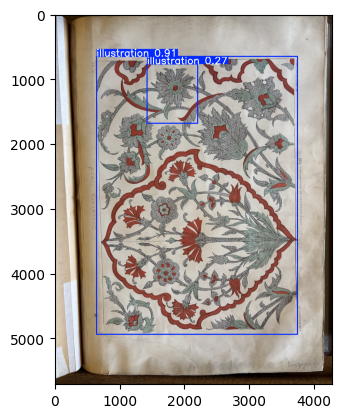

In [ ]:
import matplotlib.pyplot as plt
import cv2

resultat = test[0].plot()
plt.imshow(cv2.cvtColor(resultat, cv2.COLOR_BGR2RGB))


### çöp?

In [ ]:
# model = YOLO(model_name)
# results = model.train(data = data_dir,
#                       epochs=epochs,
#                       batch = batch,
#                       dropout=dropout,
#                       project = project,
#                       name = name,
#                       imgsz=imgsz,
#                       lr0= lr0
#                       )

Ultralytics 8.3.173 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/dataHN/experiments/yolo_doc_cls/data, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.1, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0005, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11s-cls.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=run5_yolo11s-cls2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, p

train: Scanning /content/drive/MyDrive/dataHN/experiments/yolo_doc_cls/data/train... 24 images, 0 corrupt:   3%|▎         | 24/749 [00:00<00:03, 235.09it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (131542390 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
train: Scanning /content/drive/MyDrive/dataHN/experiments/yolo_doc_cls/data/train... 749 images, 0 corrupt: 100%|██████████| 749/749 [00:04<00:00, 155.36it/s]


train: New cache created: /content/drive/MyDrive/dataHN/experiments/yolo_doc_cls/data/train.cache
val: Fast image access ✅ (ping: 2.3±3.1 ms, read: 155.5±116.3 MB/s, size: 2955.1 KB)


val: Scanning /content/drive/MyDrive/dataHN/experiments/yolo_doc_cls/data/val... 188 images, 0 corrupt: 100%|██████████| 188/188 [00:01<00:00, 102.82it/s]

val: New cache created: /content/drive/MyDrive/dataHN/experiments/yolo_doc_cls/data/val.cache


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0005' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 39 weight(decay=0.0), 40 weight(decay=0.0005), 40 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/dataHN/experiments/yolo_doc_cls/training/runs/run5_yolo11s-cls2
Starting training for 20 epochs...

      Epoch    GPU_mem       loss  Instances       Size


       1/20      5.64G      0.468         32        640:  54%|█████▍    | 13/24 [05:54<04:48, 26.20s/it]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (101181080 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00,  3.74it/s]

                   all      0.963          1



      Epoch    GPU_mem       loss  Instances       Size


       2/20      7.03G    0.09409         32        640:  88%|████████▊ | 21/24 [15:21<01:39, 33.04s/it]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (93644784 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00,  4.97it/s]

                   all      0.957          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00,  4.70it/s]

                   all      0.941          1



      Epoch    GPU_mem       loss  Instances       Size


       4/20      7.07G     0.1428         32        640:  58%|█████▊    | 14/24 [17:57<11:13, 67.38s/it]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (100104642 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00,  5.13it/s]

                   all       0.84          1



      Epoch    GPU_mem       loss  Instances       Size


       5/20      7.08G     0.1923         32        640:  75%|███████▌  | 18/24 [28:29<06:59, 69.86s/it]

In [ ]:
model = YOLO(model_name)
results = model.train(data = data_dir,
                      epochs=epochs,
                      batch = batch,
                      dropout=dropout,
                      project = project,
                      name = name
                      )

Ultralytics 8.3.174 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/dataset_resized, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.1, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=224, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11s-cls.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=run7_yolo11s-cls_img_resized, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True

AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1459.0±525.1 MB/s, size: 46.8 KB)


train: Scanning /content/dataset_resized/train... 749 images, 0 corrupt: 100%|██████████| 749/749 [00:00<00:00, 2485.06it/s]

train: New cache created: /content/dataset_resized/train.cache


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 833.5±673.9 MB/s, size: 52.7 KB)


val: Scanning /content/dataset_resized/val... 188 images, 0 corrupt: 100%|██████████| 188/188 [00:00<00:00, 6439.39it/s]

val: New cache created: /content/dataset_resized/val.cache


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 39 weight(decay=0.0), 40 weight(decay=0.0005), 40 bias(decay=0.0)
Image sizes 224 train, 224 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/dataHN/experiments/yolo_doc_cls/training/runs/run7_yolo11s-cls_img_resized
Starting training for 20 epochs...

      Epoch    GPU_mem       loss  Instances       Size


       1/20     0.506G     0.8507         16        224:   6%|▋         | 3/47 [00:02<00:22,  1.99it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:01<00:00,  4.61it/s]

                   all      0.979          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00,  9.96it/s]

                   all      0.973          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00,  7.87it/s]

                   all      0.931          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:01<00:00,  4.81it/s]

                   all      0.957          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00,  6.34it/s]

                   all      0.963          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00,  6.03it/s]

                   all      0.963          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00,  6.83it/s]

                   all      0.979          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00,  7.49it/s]

                   all      0.963          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00,  8.82it/s]

                   all      0.952          1



      Epoch    GPU_mem       loss  Instances       Size


      10/20     0.818G     0.1147         13        224: 100%|██████████| 47/47 [00:06<00:00,  7.67it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00,  6.72it/s]

                   all      0.973          1



      Epoch    GPU_mem       loss  Instances       Size


      11/20     0.836G    0.08589         13        224: 100%|██████████| 47/47 [00:07<00:00,  6.36it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00,  8.27it/s]

                   all      0.979          1



      Epoch    GPU_mem       loss  Instances       Size


      12/20     0.852G    0.06965         13        224: 100%|██████████| 47/47 [00:08<00:00,  5.75it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00,  6.73it/s]

                   all      0.979          1



      Epoch    GPU_mem       loss  Instances       Size


      13/20     0.869G    0.06883         13        224: 100%|██████████| 47/47 [00:07<00:00,  6.11it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:01<00:00,  4.30it/s]

                   all      0.984          1



      Epoch    GPU_mem       loss  Instances       Size


      14/20     0.887G    0.07011         13        224: 100%|██████████| 47/47 [00:06<00:00,  7.11it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00,  8.78it/s]

                   all      0.979          1



      Epoch    GPU_mem       loss  Instances       Size


      15/20     0.902G    0.03689         13        224: 100%|██████████| 47/47 [00:08<00:00,  5.77it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 10.27it/s]

                   all      0.973          1



      Epoch    GPU_mem       loss  Instances       Size


      16/20     0.957G    0.03745         13        224: 100%|██████████| 47/47 [00:06<00:00,  6.88it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:01<00:00,  3.58it/s]

                   all      0.979          1



      Epoch    GPU_mem       loss  Instances       Size


      17/20      1.01G    0.05648         13        224: 100%|██████████| 47/47 [00:06<00:00,  7.54it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00,  7.16it/s]

                   all      0.979          1



      Epoch    GPU_mem       loss  Instances       Size


      18/20      1.03G    0.05815         13        224: 100%|██████████| 47/47 [00:08<00:00,  5.87it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00,  6.39it/s]

                   all      0.979          1



      Epoch    GPU_mem       loss  Instances       Size


      19/20      1.04G    0.02662         13        224: 100%|██████████| 47/47 [00:06<00:00,  7.03it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:01<00:00,  4.17it/s]

                   all      0.979          1



      Epoch    GPU_mem       loss  Instances       Size


      20/20      1.06G    0.05548         13        224: 100%|██████████| 47/47 [00:06<00:00,  7.26it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00,  8.50it/s]

                   all      0.979          1



20 epochs completed in 0.052 hours.
Optimizer stripped from /content/drive/MyDrive/dataHN/experiments/yolo_doc_cls/training/runs/run7_yolo11s-cls_img_resized/weights/last.pt, 11.0MB
Optimizer stripped from /content/drive/MyDrive/dataHN/experiments/yolo_doc_cls/training/runs/run7_yolo11s-cls_img_resized/weights/best.pt, 11.0MB

Validating /content/drive/MyDrive/dataHN/experiments/yolo_doc_cls/training/runs/run7_yolo11s-cls_img_resized/weights/best.pt...
Ultralytics 8.3.174 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s-cls summary (fused): 47 layers, 5,436,690 parameters, 0 gradients, 12.0 GFLOPs
train: /content/dataset_resized/train... found 749 images in 2 classes ✅ 
val: /content/dataset_resized/val... found 188 images in 2 classes ✅ 
test: None...


               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00,  8.89it/s]


                   all      0.984          1
Speed: 0.1ms preprocess, 0.9ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to /content/drive/MyDrive/dataHN/experiments/yolo_doc_cls/training/runs/run7_yolo11s-cls_img_resized


In [ ]:
# ## Check very large file
# from tqdm import tqdm
# from PIL import Image
# from pathlib import Path

# img_dir = Path(training_dataset)
# for img_path in tqdm(img_dir.glob("**/*.*")):
#     try:
#         with Image.open(img_path) as img:
#             w, h = img.size
#             if w * h > 89_478_485:  # Pillow's default threshold
#                 print(f"Large image: {img_path.name}, size: {w}x{h}")
#     except Exception as e:
#         print(f"Corrupt or unreadable image: {img_path.name} – {e}")


239it [05:19, 20.11it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (131542390 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
259it [05:19, 27.18it/s]

Large image: Beaumont-Collinot_1880_116.jpg, size: 13174x9985


937it [05:22,  2.90it/s] 


# Inference

In [ ]:
model_best = os.path.join(project, name, 'weights','best.pt')
model_best

'/content/drive/MyDrive/dataHN/experiments/yolo_doc_ill_detect/training/runs/run8_yolo11m_1024/weights/best.pt'

In [ ]:
model = YOLO('/content/drive/MyDrive/dataHN/experiments/yolo_doc_ill_detect/training/runs/run8_yolo11m_1024/weights/best.pt')

In [ ]:
import shutil

source_folder = '/content/drive/MyDrive/dataHN/data/cleaned/doc_imgs_cleaned'
doc_imgs_colab = '/content/doc_imgs_cleaned'

shutil.copytree(source_folder, doc_imgs_colab, dirs_exist_ok=True)

'/content/doc_imgs_cleaned'

In [ ]:
print(len(os.listdir(doc_imgs_colab)))

1932


In [ ]:
#predict_data = doc_imgs_cleaned
predict_data = doc_imgs_colab

predict_images = [os.path.join(predict_data, img) for img in os.listdir(predict_data)]
len(predict_images)

1932

In [ ]:
num_training = 8
predicts_dir = os.path.join(yolo_dir, 'predicts')
project = os.path.join(predicts_dir, 'runs')
name = f'run{num_training}_{model_name.split(".")[0]}'
csv_dir = os.path.join(predicts_dir, 'csv')
os.makedirs(csv_dir, exist_ok=True)
results_csv = os.path.join(csv_dir, f'{name}_prediction_results.csv')

'/content/drive/MyDrive/dataHN/experiments/yolo_doc_ill_detect/predicts/runs/run8_yolo11m/weights/best.pt'

In [ ]:

# Diviser liste images en sections pour éviter surcharge RAM
sections = np.array_split(predict_images, 100)
sections = [list(section) for section in sections]

model_best = YOLO(model_best)


for i, section_data in enumerate(sections):
    print(f"Processing section {i+1}/100...")

    results = model_best.predict(section_data, project=project, name = name, batch=4)

    all_results = []
    for result in results:
        image_path = result.path
        filename = os.path.basename(image_path)
        class_names = result.names
        boxes = result.boxes

        if boxes is None or len(boxes) == 0:
            continue  # no detections

        for j, box in enumerate(boxes):
            cls_id = int(box.cls.item())
            conf = float(box.conf.item())
            x1, y1, x2, y2 = box.xyxy.cpu().numpy().tolist()[0]

            all_results.append({
                'image_file': filename,
                'class_id': cls_id,
                'class_name': class_names[cls_id],
                'score': conf,
                'x1': x1,
                'y1': y1,
                'x2': x2,
                'y2': y2,
                'bbox_index': j
            })


    df_section = pd.DataFrame(all_results)
    df_section.to_csv(results_csv, mode='a', index=False, header=(i == 0))

    torch.cuda.empty_cache()


Processing section 1/100...

0: 640x640 1 illustration, 24.7ms
1: 640x640 2 illustrations, 24.7ms
2: 640x640 1 illustration, 24.7ms
3: 640x640 8 illustrations, 24.7ms
4: 640x640 9 illustrations, 24.7ms
5: 640x640 8 illustrations, 24.7ms
6: 640x640 4 illustrations, 24.7ms
7: 640x640 1 illustration, 24.7ms
8: 640x640 1 illustration, 24.7ms
9: 640x640 1 illustration, 24.7ms
10: 640x640 4 illustrations, 24.7ms
11: 640x640 4 illustrations, 24.7ms
12: 640x640 1 illustration, 24.7ms
13: 640x640 27 illustrations, 24.7ms
14: 640x640 6 illustrations, 24.7ms
15: 640x640 2 illustrations, 24.7ms
16: 640x640 1 illustration, 24.7ms
17: 640x640 11 illustrations, 24.7ms
18: 640x640 1 illustration, 24.7ms
19: 640x640 1 illustration, 24.7ms
Speed: 3.3ms preprocess, 24.7ms inference, 0.9ms postprocess per image at shape (4, 3, 640, 640)
Processing section 2/100...

0: 640x640 3 illustrations, 25.6ms
1: 640x640 2 illustrations, 25.6ms
2: 640x640 7 illustrations, 25.6ms
3: 640x640 6 illustrations, 25.6ms
4:

/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (131396860 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


0: 640x640 4 illustrations, 23.6ms
1: 640x640 1 illustration, 23.6ms
2: 640x640 1 illustration, 23.6ms
3: 640x640 1 illustration, 23.6ms
4: 640x640 6 illustrations, 23.6ms
5: 640x640 3 illustrations, 23.6ms
6: 640x640 2 illustrations, 23.6ms
7: 640x640 5 illustrations, 23.6ms
8: 640x640 3 illustrations, 23.6ms
9: 640x640 10 illustrations, 23.6ms
10: 640x640 2 illustrations, 23.6ms
11: 640x640 4 illustrations, 23.6ms
12: 640x640 6 illustrations, 23.6ms
13: 640x640 2 illustrations, 23.6ms
14: 640x640 3 illustrations, 23.6ms
15: 640x640 1 illustration, 23.6ms
16: 640x640 5 illustrations, 23.6ms
17: 640x640 4 illustrations, 23.6ms
18: 640x640 1 illustration, 23.6ms
19: 640x640 10 illustrations, 23.6ms
Speed: 4.8ms preprocess, 23.6ms inference, 1.3ms postprocess per image at shape (4, 3, 640, 640)
Processing section 21/100...

0: 640x640 1 illustration, 25.3ms
1: 640x640 2 illustrations, 25.3ms
2: 640x640 3 illustrations, 25.3ms
3: 640x640 2 illustrations, 25.3ms
4: 640x640 1 illustration, 

/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (131542390 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


0: 640x640 2 illustrations, 23.6ms
1: 640x640 7 illustrations, 23.6ms
2: 640x640 1 illustration, 23.6ms
3: 640x640 2 illustrations, 23.6ms
4: 640x640 1 illustration, 23.6ms
5: 640x640 1 illustration, 23.6ms
6: 640x640 6 illustrations, 23.6ms
7: 640x640 4 illustrations, 23.6ms
8: 640x640 1 illustration, 23.6ms
9: 640x640 1 illustration, 23.6ms
10: 640x640 1 illustration, 23.6ms
11: 640x640 1 illustration, 23.6ms
12: 640x640 4 illustrations, 23.6ms
13: 640x640 3 illustrations, 23.6ms
14: 640x640 1 illustration, 23.6ms
15: 640x640 1 illustration, 23.6ms
16: 640x640 3 illustrations, 23.6ms
17: 640x640 4 illustrations, 23.6ms
18: 640x640 1 illustration, 23.6ms
Speed: 3.4ms preprocess, 23.6ms inference, 0.9ms postprocess per image at shape (4, 3, 640, 640)
Processing section 74/100...

0: 640x640 2 illustrations, 24.5ms
1: 640x640 28 illustrations, 24.5ms
2: 640x640 1 illustration, 24.5ms
3: 640x640 2 illustrations, 24.5ms
4: 640x640 6 illustrations, 24.5ms
5: 640x640 2 illustrations, 24.5ms

In [ ]:
all_results[1]

# Crop detections

In [ ]:
from tqdm import tqdm

In [ ]:
import pandas as pd
import os
import cv2

def crop_yolo_detections(csv_path, output_dir, output_csv_path):
    df = pd.read_csv(csv_path)

    os.makedirs(output_dir, exist_ok=True)
    crop_data = []

    # Group detections by image file
    grouped = df.groupby("image")

    for image_path, group in tqdm(grouped):
        try:
            image = cv2.imread(image_path)
            if image is None:
                print(f"L'image n'a pas pu être chargée : {image_path}")
                continue

            filename = os.path.splitext(os.path.basename(image_path))[0]

            # Use itertuples for clearer, faster iteration
            for crop_id, row in enumerate(group.itertuples(index=False), start=1):
                x1, y1, x2, y2 = map(int, [row.x1, row.y1, row.x2, row.y2])
                crop = image[y1:y2, x1:x2]

                crop_filename = f"{filename}_{crop_id:02d}.jpg"
                crop_path = os.path.join(output_dir, crop_filename)
                cv2.imwrite(crop_path, crop)

                crop_data.append({
                    "crop_file": crop_path,
                    "confidence": row.confidence
                })

        except Exception as e:
            print(f"Erreur {image_path}: {e}")

    # Save output CSV with crop metadata
    pd.DataFrame(crop_data).to_csv(output_csv_path, index=False)


In [ ]:
cropped_output_dir = os.path.join(PROCESSED, 'docs_yolo_ill_det_cropped')
output_csv = os.path.join(csv_dir, 'yolo_detections_cropped.csv')

In [ ]:
crop_yolo_detections(results_csv, cropped_output_dir, output_csv)

100%|██████████| 1908/1908 [15:31<00:00,  2.05it/s]
